In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/generated-prompt1/gen_data_Distance learning.csv
/kaggle/input/persaude-corpus-2/persuade_corpus_1.0.csv
/kaggle/input/persaude-corpus-2/persuade_2.0_human_scores_demo_id_github.csv
/kaggle/input/persaude-corpus-2/sources.csv
/kaggle/input/llm-detect-ai-generated-text/sample_submission.csv
/kaggle/input/llm-detect-ai-generated-text/train_prompts.csv
/kaggle/input/llm-detect-ai-generated-text/test_essays.csv
/kaggle/input/llm-detect-ai-generated-text/train_essays.csv
/kaggle/input/llm-generated-essays/ai_generated_train_essays.csv
/kaggle/input/llm-generated-essays/ai_generated_train_essays_gpt-4.csv
/kaggle/input/augmented-data-for-llm-detect-ai-generated-text/final_train.csv
/kaggle/input/augmented-data-for-llm-detect-ai-generated-text/final_test.csv
/kaggle/input/tokenizer/merges.txt
/kaggle/input/tokenizer/vocab.json
/kaggle/input/tokenizer/tokenizer_config.json
/kaggle/input/tokenizer/special_tokens_map.json
/kaggle/input/mistral/pytorch/7b-instruct-v0.1-hf/1/config.j

## I- Data Preparation

Let's first prepare the dataset: We'll choose 3 different prompts from the persuade corpus with 400 student written essays for each, and we'll generate for each prompt 400 essays using Mistral7B. There will be in the end 3 dataframes with two columns : 
* "text" (str): the responses to the prompt 
* "generated" (bool): wether the responses are AI generated or not.
Each one of these 3 dataframes corresponds to one of the chosen prompts.

In [2]:
# configurations
prompts_names = ["Distance learning", "Does the electoral college work?","Community service"]
n_essays = 400

### 1. Non generated essays preparation

In [3]:
# preparing dataframes for non generated essays
all_df = pd.read_csv("/kaggle/input/daigt-v2-train-dataset/train_v2_drcat_02.csv")
all_df.rename(columns={'label': 'generated'}, inplace=True)
all_df = all_df[all_df["generated"]==0]
all_df_prompt0 = all_df[all_df["prompt_name"]==prompts_names[0]].head(n_essays)
all_df_prompt0.drop(columns=["prompt_name", "source", "RDizzl3_seven"], inplace=True)
all_df_prompt1 = all_df[all_df["prompt_name"]==prompts_names[1]].head(n_essays)
all_df_prompt1.drop(columns=["prompt_name", "source", "RDizzl3_seven"], inplace=True)
all_df_prompt2 = all_df[all_df["prompt_name"]==prompts_names[2]].head(n_essays)
all_df_prompt2.drop(columns=["prompt_name", "source", "RDizzl3_seven"], inplace=True)

In [4]:
# mean length of texts
import statistics
lengths = [len(all_df_prompt0["text"].iloc[i]) for i in range(400)]
statistics.mean(lengths)

3316.77

### 2- Generating essays using Mistral7B

In [5]:
# getting prompts instructions from persuade corpus
persuade_corpus = pd.read_csv("/kaggle/input/persaude-corpus-2/persuade_2.0_human_scores_demo_id_github.csv")
assignements = persuade_corpus["assignment"][persuade_corpus["prompt_name"].isin(prompts_names)].drop_duplicates()

In [6]:
assignements.iloc[2]

'Some schools offer distance learning as an option for students to attend classes from home by way of online or video conferencing. Do you think students would benefit from being able to attend classes from home? Take a position on this issue. Support your response with reasons and examples.'

In [7]:
persuade_corpus["prompt_name"].value_counts()

prompt_name
Facial action coding system              2167
Distance learning                        2157
Does the electoral college work?         2046
Car-free cities                          1959
Driverless cars                          1886
Exploring Venus                          1862
Summer projects                          1750
Mandatory extracurricular activities     1670
Cell phones at school                    1656
Grades for extracurricular activities    1626
The Face on Mars                         1583
Seeking multiple opinions                1552
Community service                        1542
"A Cowboy Who Rode the Waves"            1372
Phones and driving                       1168
Name: count, dtype: int64

In [7]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

In [ ]:
# importing model and tokenizer
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
model_path = "/kaggle/input/mistral/pytorch/7b-instruct-v0.1-hf/1"
gen_tokenizer = AutoTokenizer.from_pretrained(model_path)
gen_model = AutoModelForCausalLM.from_pretrained(
    model_path,
    torch_dtype = torch.bfloat16,
    device_map = "auto",
    trust_remote_code = True
)

In [ ]:
# function to generate an essay
def generate(prompt):
    # generate essays
    messages = [{
        "role" : "user",
        "content": prompt,
    }]
    model_inputs = gen_tokenizer.apply_chat_template(
        messages,
        return_tensors = "pt",
    )
    generated_ids = gen_model.generate(model_inputs, max_new_tokens = 4000, do_sample= True)
    essay = gen_tokenizer.batch_decode(generated_ids)[0]
    essay = essay.split('[/INST]')[1]
    essay = essay.replace('</s>', "")
    return essay

In [ ]:
# create the generated essays dataframes
gen_df0 = pd.DataFrame({"text": [generate(assignements.iloc[2])], "generated": [1]})
gen_df1 = pd.DataFrame({"text": [generate(assignements.iloc[1])], "generated": [1]}) 
gen_df2 = pd.DataFrame({"text": [generate(assignements.iloc[0])], "generated": [1]})

# filling the dataframes with 400 generated essays
def fill_gen_df(df, prompt):
    for i in range(n_essays - 1):
        new_row = pd.DataFrame({"text": [generate(prompt)], "generated": [1]})
        df = pd.concat([df, new_row])
    return df

In [ ]:
gen_df0 = fill_gen_df(gen_df0, assignements.iloc[2])
gen_df0.to_csv("gen_data_1.csv")
gen_df1 = fill_gen_df(gen_df1, assignements.iloc[1])
gen_df1.to_csv("gen_data_2.csv")
gen_df2 = fill_gen_df(gen_df2, assignements.iloc[0])
gen_df2.to_csv("gen_data_3.csv")

In [ ]:
# gen_df0 = pd.read_csv("/kaggle/input/generated-prompt1/gen_data_1.csv")
# gen_df1 = pd.read_csv("/kaggle/input/gen-data-prompt2/gen_data_2.csv")

### 3- Final Dataset

In [ ]:
# concatenating datasets
data_prompt0 = pd.concat([all_df_prompt0, gen_df0])
data_prompt1 = pd.concat([all_df_prompt1, gen_df1])
data_prompt2 = pd.concat([all_df_prompt2, gen_df2])

In [10]:
print(f"Number of AI generated essays: {(data_prompt1['generated']==1).sum()}")
print(f"Number of real essays: {(data_prompt1['generated']==0).sum()}")

Number of AI generated essays: 400
Number of real essays: 400


In [ ]:
data_prompt0.to_csv("data_Distance learning.csv")
data_prompt1.to_csv("data_Doestheelectoralcollegework.csv")
data_prompt2.to_csv("data_Community service.csv")

# II- Longformer fine-tuning

### 1- Data Splitting

In [11]:
from transformers import AutoModelForSequenceClassification, LongformerTokenizer, LongformerForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import TensorDataset
import torch.nn as nn
import torch.optim as optim
import re
from sklearn import feature_extraction, linear_model, model_selection, metrics

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [12]:
# split the data into train, test and validation sets
def splitting_data(data):
    X_train, X_val, y_train, y_val = model_selection.train_test_split(data["text"], data["generated"], test_size=0.3, random_state=42)
    return X_train,X_val, y_train, y_val

X_train_prompt0, X_val_prompt0, y_train_prompt0, y_val_prompt0 = splitting_data(data_prompt0)
X_train_prompt1, X_val_prompt1, y_train_prompt1, y_val_prompt1 = splitting_data(data_prompt1)
#X_train_prompt2, X_val_prompt2, y_train_prompt2, y_val_prompt2 = splitting_data(data_prompt2)

#### 2- pretrained-model and tokenizer preparing

In [13]:
# Define paths for each file
input_dir_model = '/kaggle/input/longformer-model/'
input_dir_tok = '/kaggle/input/tokenizer/'

model_path = os.path.join(input_dir_model, 'model.safetensors')
tokenizer_path = os.path.join(input_dir_tok, 'vocab.json')
config_path = os.path.join(input_dir_model, 'config.json')
merges_path = os.path.join(input_dir_tok, 'merges.txt')
special_tokens_map_path = os.path.join(input_dir_tok, 'special_tokens_map.json')
token_config_path = os.path.join(input_dir_tok, 'tokenizer_config.json')


# Load the pretrained model and tokenizer
model_prompt0 = LongformerForSequenceClassification.from_pretrained(input_dir_model)
tokenizer = LongformerTokenizer(vocab_file=tokenizer_path, merges_file=merges_path, 
                                tokenizer_file=config_path, special_tokens_map_file=special_tokens_map_path,
                                token_config_file=token_config_path)

In [14]:
# Freeze base model parameters
def freeze_base_param(model):
    for param in model.base_model.parameters():
        param.requires_grad = False
freeze_base_param(model_prompt0)

#### 4- Data processing

In [15]:
# data tokenization
def tokenization(batched_text):
    return tokenizer(batched_text['text'], padding = 'max_length', truncation=True, max_length = 4096)

def tokenize_data(X, y):
    text_data = X.tolist()
    label_data = y.tolist()
    formatted_data = [{'text': text_data[i], 'label': label_data[i]} for i in range(len(text_data))]
    tokenized_data = list(map(tokenization, formatted_data))
    for i in range(len(tokenized_data)):
        tokenized_data[i]["label"] = label_data[i]
    return tokenized_data

train_data_prompt0 = tokenize_data(X_train_prompt0, y_train_prompt0)
train_data_prompt1 = tokenize_data(X_train_prompt1, y_train_prompt1)
val_data_prompt0 = tokenize_data(X_val_prompt0, y_val_prompt0)
val_data_prompt1 = tokenize_data(X_val_prompt1, y_val_prompt1)
"""train_data_prompt2 = tokenize_data(X_train_prompt2, y_train_prompt2)
val_data_prompt2 = tokenize_data(X_val_prompt2, y_val_prompt2)"""

'train_data_prompt2 = tokenize_data(X_train_prompt2, y_train_prompt2)\nval_data_prompt2 = tokenize_data(X_val_prompt2, y_val_prompt2)'

#### 5- Trainer preparing

In [16]:
# computing metrics during training
from sklearn.metrics import roc_auc_score
def compute_metrics(pred):
    labels=pred.label_ids
    preds= pred.predictions.argmax(-1)
    roc_auc = roc_auc_score(preds, labels)
    return {"roc_auc":roc_auc}

In [17]:
# training args for longformer trainer
training_args = TrainingArguments(
    output_dir='/kaggle/working"',  # Output directory
    num_train_epochs=3,
    learning_rate=2e-3,# Number of training epochs
    per_device_train_batch_size=10,  # Batch size per device during training
    per_device_eval_batch_size=10,   # Batch size for evaluation
    #warmup_steps=500,  # Number of warmup steps for learning rate scheduler
    weight_decay=0.01,
    fp16=True,
    evaluation_strategy="epoch",
    logging_steps=1,# Strength of weight decay
    report_to="none",
)

In [18]:
# New Trainer class inheriting from Hugging Face Trainer class to get hidden layers
class Trainer_prompt(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        outputs = model(**inputs)
        logits = outputs.get("logits")
        labels = inputs.get("labels")
        loss_function = nn.CrossEntropyLoss()
        loss = loss_function(logits, labels)
        return (loss, outputs) if return_outputs else loss
    def get_hidden_out_proj(self, model, inputs):
        outputs = model(**inputs,output_hidden_states= True)
        hidden_states = outputs.hidden_states[-1][:, 0, :]  # take <s> token (equiv. to [CLS])
        hidden_states = self.model.classifier.dropout(hidden_states)
        hidden_states = self.model.classifier.dense(hidden_states)
        intermediate_output = torch.tanh(hidden_states)
        hidden_states = self.model.classifier.dropout(intermediate_output)
        output = self.model.classifier.out_proj(hidden_states)
        return intermediate_output, output 
    def predict_out_proj(
        self, test_dataset, ignore_keys= None, metric_key_prefix: str = "test"
    ):
        test_dataloader = self.get_test_dataloader(test_dataset)
        model = self._wrap_model(self.model, training=False, dataloader=test_dataloader)
        hidden_state = None
        for step, inputs in enumerate(test_dataloader):
            hidden_state, output = self.get_hidden_out_proj(model, inputs)
        return hidden_state, output
    def predict_dense(
        self, test_dataset, ignore_keys= None, metric_key_prefix: str = "test"
    ):
        test_dataloader = self.get_test_dataloader(test_dataset)
        model = self._wrap_model(self.model, training=False, dataloader=test_dataloader)
        hidden_state = None
        for step, inputs in enumerate(test_dataloader):
            hidden_state, output = self.get_hidden_dense(model, inputs)
        return hidden_state, output
    def get_hidden_dense(self, model, inputs):
        outputs = model(**inputs,output_hidden_states= True)
        hidden_states = outputs.hidden_states[-1][:, 0, :]  # take <s> token (equiv. to [CLS])
        return hidden_states, outputs 
    
        

In [19]:
trainer_prompt0 = Trainer_prompt(
    model_prompt0,
    training_args,
    train_dataset=train_data_prompt0,
    eval_dataset=val_data_prompt0,
    compute_metrics=compute_metrics,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_prompt0.to(device)

LongformerForSequenceClassification(
  (longformer): LongformerModel(
    (embeddings): LongformerEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (position_embeddings): Embedding(4098, 768, padding_idx=1)
    )
    (encoder): LongformerEncoder(
      (layer): ModuleList(
        (0-11): 12 x LongformerLayer(
          (attention): LongformerAttention(
            (self): LongformerSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (query_global): Linear(in_features=768, out_features=768, bias=True)
              (key_global): Linear(in_features=768, out_features=768, bias=True)
          

#### 6- Model Training on prompt 0

In [20]:
trainer_prompt0.train()

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Roc Auc
1,0.160100,0.097321,0.956349
2,0.025600,0.010793,0.995690
3,0.001400,0.005088,0.995690


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


TrainOutput(global_step=84, training_loss=0.08556935819502715, metrics={'train_runtime': 564.5879, 'train_samples_per_second': 2.976, 'train_steps_per_second': 0.149, 'total_flos': 4414042830274560.0, 'train_loss': 0.08556935819502715, 'epoch': 3.0})

#### 7- Model Testing

In [21]:
# preparing test data
test_data = val_data_prompt0 + val_data_prompt1

# getting test predictions
predictions_prompt1 = trainer_prompt0.predict(val_data_prompt1)
predictions_prompt0 = trainer_prompt0.predict(val_data_prompt0)
predictions = list(predictions_prompt0.predictions) + list(predictions_prompt1.predictions)

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [22]:
# testing the model and displaying roc-auc scores
def testing_results(predictions, test_data):
    preds= predictions.argmax(-1)
    labels = []
    for i in range(len(test_data)):
        labels.append(test_data[i]["label"])
    roc_auc = roc_auc_score(preds, labels)
    return roc_auc

print(f"roc_auc on both prompt0 and prompt1 validations data: {testing_results(np.array(predictions), test_data)}")
print(f"roc_auc on prompt0 validation data: {testing_results(predictions_prompt0.predictions, val_data_prompt0)}")
print(f"roc_auc on prompt1 validation data: {testing_results(predictions_prompt1.predictions, val_data_prompt1)}")

roc_auc on both prompt0 and prompt1 validations data: 0.9780059674408054
roc_auc on prompt0 validation data: 0.9956896551724138
roc_auc on prompt1 validation data: 0.9614925163375727


In [23]:
# analysing bad predictions
def get_bad_pred_number(predictions, test_data):
    preds= predictions.argmax(-1)
    labels = []
    for i in range(len(test_data)):
        labels.append(test_data[i]["label"])
    num_gen = np.sum((preds != labels) & (preds == 0))
    num_non_gen = np.sum((preds != labels) & (preds == 1))
    return num_gen, num_non_gen

bad_preds_df = pd.DataFrame({
    "prompt": ["prompt0", "prompt1"],
    "num bad predictions generated": [
        get_bad_pred_number(predictions_prompt0.predictions, val_data_prompt0)[0],
        get_bad_pred_number(predictions_prompt1.predictions, val_data_prompt1)[0]
    ],
    "num bad predictions non_generated": [
        get_bad_pred_number(predictions_prompt0.predictions, val_data_prompt0)[1],
        get_bad_pred_number(predictions_prompt1.predictions, val_data_prompt1)[1]
    ]
})
bad_preds_df

,prompt,num bad predictions generated,num bad predictions non_generated
0,prompt0,0,1
1,prompt1,9,1


# III- Studying Logits difference

In this section we will compare the logits difference between predictions made on data from  prompt0 and data from other prompts using histograms. In fact logits difference gives good indications about model's confidence, so we want here to study and compare the confidence of the model on prompts it was trained on with unseen prompts.   

In [24]:
# plotting the histogram in regard to the class of the prediction
def diff_logits_class(predictions, generated):
    preds= predictions.predictions.argmax(-1)
    indices = np.where(preds == generated)[0]
    class_preds = predictions.predictions[indices]
    logits_difference = class_preds[:, 0] - class_preds[:, 1]
    return logits_difference

#### 1- prompt0 vs prompt1

In [25]:
predictions_prompt1 = trainer_prompt0.predict(val_data_prompt1)
predictions_prompt0 = trainer_prompt0.predict(val_data_prompt0)

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Text(0.5, 1.0, 'prompt1 model histogram for AI generated predictions')

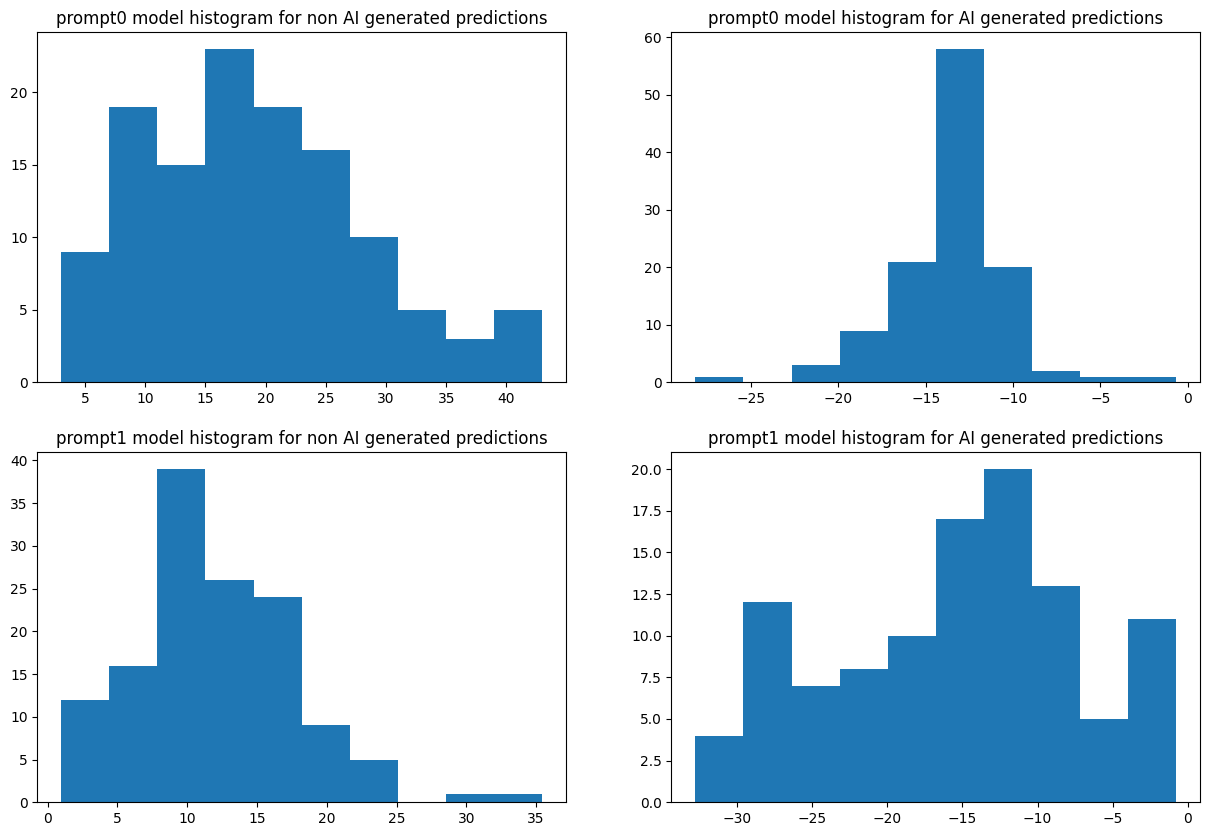

In [26]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Plotting histograms
axs[0][0].hist(diff_logits_class(predictions_prompt0, 0))
axs[0][0].set_title("prompt0 model histogram for non AI generated predictions")

axs[0][1].hist(diff_logits_class(predictions_prompt0, 1))
axs[0][1].set_title("prompt0 model histogram for AI generated predictions")

axs[1][0].hist(diff_logits_class(predictions_prompt1, 0))
axs[1][0].set_title("prompt1 model histogram for non AI generated predictions")

axs[1][1].hist(diff_logits_class(predictions_prompt1, 1))
axs[1][1].set_title("prompt1 model histogram for AI generated predictions")

# IV- Hidden Layers comparision

In this section, we try to see if semantic related features are well separated from other features in the last layer of our model. In order to do this, we will study the activation of the penultimate layer of the model on texts from prompt0  and compare it to unseen prompts: We will see if there are some specific activations of the penultimate layer which are more sensible to semantic differences between different prompts.

#### 1- Data preparation

In [27]:
# validation propmpt0 sample
gen_val_data_prompt0 = [sample for sample in val_data_prompt0 if sample["label"] == 1]
non_gen_val_data_prompt0 = [sample for sample in val_data_prompt0 if sample["label"] == 0]
gen_val_sample = gen_val_data_prompt0[0]
non_gen_val_sample = non_gen_val_data_prompt0[0]

In [ ]:
# validation propmpt0 sample
gen_val_data_prompt2 = [sample for sample in val_data_prompt2 if sample["label"] == 1]
non_gen_val_data_prompt2 = [sample for sample in val_data_prompt2 if sample["label"] == 0]

In [28]:
# validation propmpt1 sample
gen_val_data_prompt1 = [sample for sample in val_data_prompt1 if sample["label"] == 1]
non_gen_val_data_prompt1 = [sample for sample in val_data_prompt1 if sample["label"] == 0]
gen_val_sample_prompt1 = gen_val_data_prompt1[0]
non_gen_val_sample_prompt1 = non_gen_val_data_prompt1[0]

#### 2_ Method 1: Pnultimate layer activations sign comparision

Our first method is to study the difference in sign of penultimate layer activations between predictions on prompt0 and predictions on model's unseen prompts.

In [29]:
def outputs_comparision(model, sample1, sample2):
    # testing the model on the two texts
    hidden_state1, output1 = model.predict_out_proj([sample1])
    hidden_state2, output2 = model.predict_out_proj([sample2])
    return hidden_state1, output1, hidden_state2, output2

In [30]:
# inputs of opposite sign
def get_opposite_outputs(dense_output1, dense_output2):
    dense_output1 = dense_output1.flatten().cpu().detach().numpy()
    dense_output2 = dense_output2.flatten().cpu().detach().numpy()
    indexes = np.where(np.sign(dense_output1) != np.sign(dense_output2))[0]
    return indexes

In [31]:
# get the prediction
def max_logits(pred):
    return pred.argmax(-1).item()

In [32]:
import random
from itertools import product
# getting intersection of indexes
def intersection_datas(model, data1, data2, opposite=True):
    data1 = random.sample(data1, k=1)
    data2 = random.sample(data2, k=1)
    intersection = np.arange(769)
    all_pairs = list(product(data1, data2))
    for sample1, sample2 in all_pairs:
        hidden_state1, output1, hidden_state2, output2 = outputs_comparision(model, sample1, sample2)
        if opposite:
            indexes = get_opposite_outputs(hidden_state1, hidden_state2)
        else:
            indexes = get_equal_sign_outputs(hidden_state1, hidden_state2)
        if max_logits(output1) == sample1["label"] and max_logits(output2) == sample2["label"]:
            intersection = np.intersect1d(intersection, indexes)
    return intersection
        

In [33]:
import matplotlib.pyplot as plt
def count_sensible_neurons(model, data1, data2, opposite=True):
    intersections=[]
    for i in range(1000):
        one_intersection = intersection_datas(model, data1, data2)
        intersections.append(one_intersection)
    # Create a dictionary to store counts of each number
    number_counts = {}

    # Count occurrences of each number across arrays
    for intersection in intersections:
        for num in intersection:
            if num not in number_counts:
                number_counts[num] = 1
            else:
                number_counts[num] += 1

    # Create lists for x-axis (numbers) and y-axis (counts)
    numbers = np.arange(1, 769)
    counts = [number_counts.get(num, 0) for num in numbers]  # Get counts or default to 0 if number not found

    # Create a bar plot
    plt.bar(numbers, counts)
    plt.xlabel('Activations position')
    plt.ylabel('Count of opposite activations')
    plt.title('Count of activations opposite signs between pairs of prompt0 and prompt1 predictions')
    plt.show()
    return number_counts

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


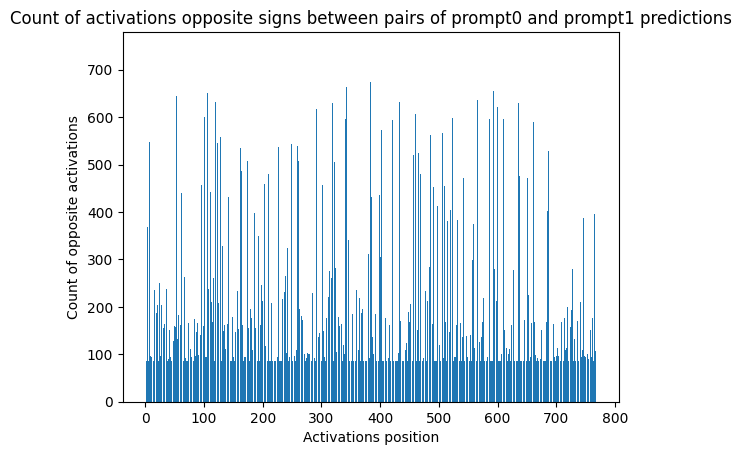

In [34]:
counts_per_neuron_out_proj = count_sensible_neurons(trainer_prompt0, gen_val_data_prompt1, gen_val_data_prompt0)

In [35]:
# selecting the most sensible activations to semantic features
treshold = 190
sensible_out_proj_activations = [neuron for neuron in counts_per_neuron_out_proj.keys() if counts_per_neuron_out_proj[neuron]>treshold]

In [36]:
len(sensible_out_proj_activations)

241

#### 3- Method 2: Statistical Test for last activations distributions

In this section we will use the KS-Test to compare the distribution of prompt0 predictions last activations with the distribution of unseen prompts predictions last activations.

In [ ]:
from scipy.stats import ks_2samp

def get_hidden_states_prompts(trainer, data1, data2):
    hidden_states1 = []
    hidden_states2=[]
    for sample in data1:
        hidden_state1, _ = trainer.predict_out_proj([sample])
        hidden_states1.append(hidden_state1.flatten().cpu().detach().numpy())
    for sample in data2:
        hidden_state2, _ = trainer.predict_out_proj([sample])
        hidden_states2.append(hidden_state2.flatten().cpu().detach().numpy())
    return hidden_states1, hidden_states2

def KS_test(trainer, data1, data2):
    hidden_states1, hidden_states2 = get_hidden_states_prompts(trainer, data1, data2)
    ks_p_values = [ks_2samp(np.array(hidden_states1)[:,i], np.array(hidden_states2)[:,i])[1] for i in range(len(hidden_states1[0]))]
    return ks_p_values
    

In [ ]:
ks_p_values = KS_test(trainer_prompt0, gen_val_data_prompt1, gen_val_data_prompt0)

In [ ]:
sensible_out_proj_activations_kstest = [neuron for neuron in range(len(ks_p_values)) if ks_p_values[neuron]<0.05]

In [ ]:
len(sensible_out_proj_activations_kstest)

#### 4- Commonality between the two methods

In [ ]:
common_elements = set(sensible_out_proj_activations_kstest) & set(sensible_out_proj_activations)
num_common_elements = len(common_elements)

In [ ]:
list(common_elements)

In [ ]:
num_common_elements

# Ignoring semantic features using weight decay 

In [42]:
class Regularized_Trainer_prompt(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        outputs = model(**inputs)
        logits = outputs.get("logits")
        labels = inputs.get("labels")
        loss_function = nn.CrossEntropyLoss()
        loss = loss_function(logits, labels)
        
        # Adding weight decay to specific indices
        weight_decay = 0.1  # Example weight decay factor
        for name, param in self.model.classifier.out_proj.named_parameters():
            if name == 'weight':
                loss += torch.sum(torch.abs(param[:, sensible_out_proj_activations]) * weight_decay)
        return (loss, outputs) if return_outputs else loss
    def get_hidden_out_proj(self, model, inputs):
        outputs = model(**inputs,output_hidden_states= True)
        hidden_states = outputs.hidden_states[-1][:, 0, :]  # take <s> token (equiv. to [CLS])
        hidden_states = self.model.classifier.dropout(hidden_states)
        hidden_states = self.model.classifier.dense(hidden_states)
        intermediate_output = torch.tanh(hidden_states)
        hidden_states = self.model.classifier.dropout(intermediate_output)
        output = self.model.classifier.out_proj(hidden_states)
        return intermediate_output, output 
    def predict_out_proj(
        self, test_dataset, ignore_keys= None, metric_key_prefix: str = "test"
    ):
        test_dataloader = self.get_test_dataloader(test_dataset)
        model = self._wrap_model(self.model, training=False, dataloader=test_dataloader)
        hidden_state = None
        for step, inputs in enumerate(test_dataloader):
            hidden_state, output = self.get_hidden_out_proj(model, inputs)
        return hidden_state, output
    def predict_dense(
        self, test_dataset, ignore_keys= None, metric_key_prefix: str = "test"
    ):
        test_dataloader = self.get_test_dataloader(test_dataset)
        model = self._wrap_model(self.model, training=False, dataloader=test_dataloader)
        hidden_state = None
        for step, inputs in enumerate(test_dataloader):
            hidden_state, output = self.get_hidden_dense(model, inputs)
        return hidden_state, output
    def get_hidden_dense(self, model, inputs):
        outputs = model(**inputs,output_hidden_states= True)
        hidden_states = outputs.hidden_states[-1][:, 0, :]  # take <s> token (equiv. to [CLS])
        return hidden_states, outputs 

In [43]:
# freezing first dense layer of classifier head
for param in model_prompt0.classifier.dense.parameters():
    param.requires_grad = False

In [44]:
import gc         # garbage collect library
gc.collect()
torch.cuda.empty_cache() 

In [45]:
regularized_trainer_prompt0 = Regularized_Trainer_prompt(
    model_prompt0,
    training_args,
    train_dataset=train_data_prompt0,
    eval_dataset=val_data_prompt0,
    compute_metrics=compute_metrics,
)

In [46]:
regularized_trainer_prompt0.train()

Epoch,Training Loss,Validation Loss,Roc Auc
1,0.366600,0.317618,0.995690
2,0.048300,0.049951,0.995690
3,0.012400,0.016787,0.995690


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


TrainOutput(global_step=84, training_loss=0.3735265601426363, metrics={'train_runtime': 565.3491, 'train_samples_per_second': 2.972, 'train_steps_per_second': 0.149, 'total_flos': 4414042830274560.0, 'train_loss': 0.3735265601426363, 'epoch': 3.0})

# Regularized Model difference of logits study

In [47]:
predictions_prompt1 = regularized_trainer_prompt0.predict(val_data_prompt1)
predictions_prompt0 = regularized_trainer_prompt0.predict(val_data_prompt0)

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Text(0.5, 1.0, 'prompt1 model histogram for AI generated predictions')

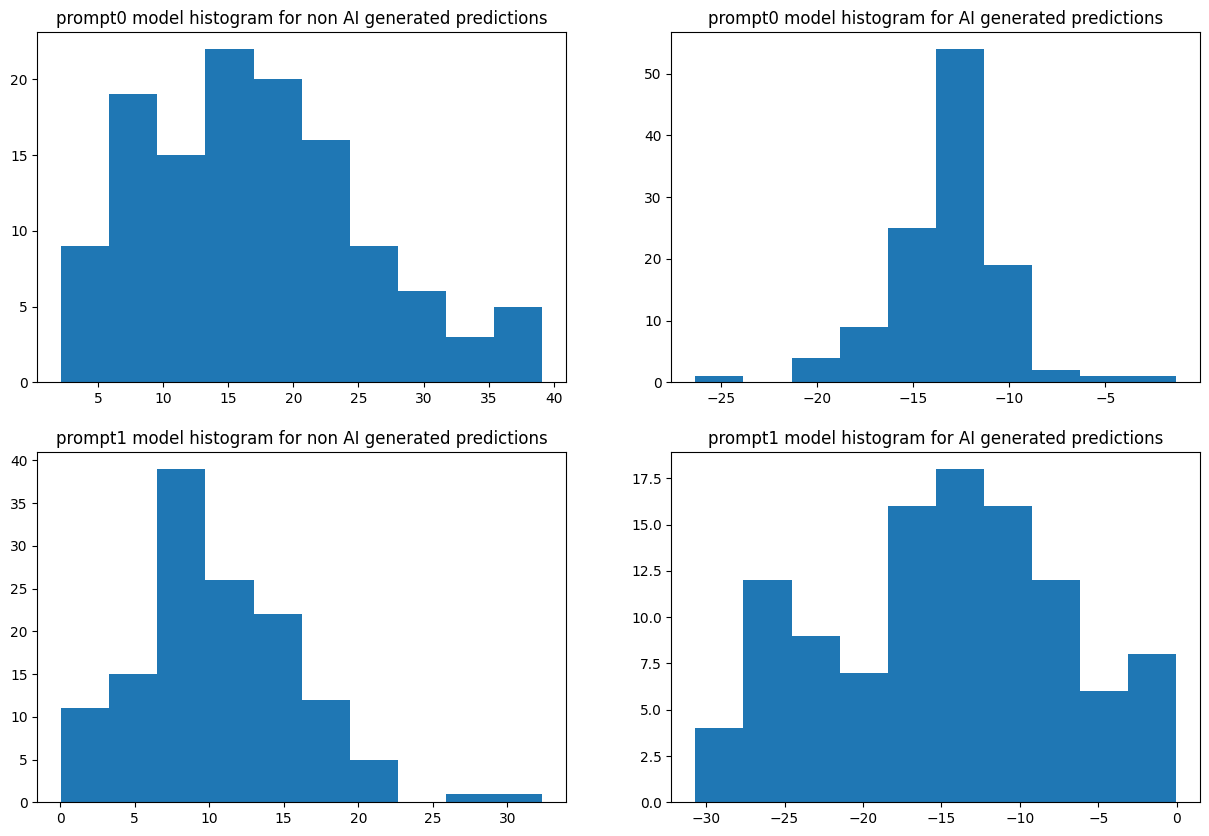

In [48]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Plotting histograms
axs[0][0].hist(diff_logits_class(predictions_prompt0, 0))
axs[0][0].set_title("prompt0 model histogram for non AI generated predictions")

axs[0][1].hist(diff_logits_class(predictions_prompt0, 1))
axs[0][1].set_title("prompt0 model histogram for AI generated predictions")

axs[1][0].hist(diff_logits_class(predictions_prompt1, 0))
axs[1][0].set_title("prompt1 model histogram for non AI generated predictions")

axs[1][1].hist(diff_logits_class(predictions_prompt1, 1))
axs[1][1].set_title("prompt1 model histogram for AI generated predictions")

In [ ]:
predictions_prompt2 = regularized_trainer_prompt0.predict(val_data_prompt2)

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Plotting histograms
axs[0][0].hist(diff_logits_class(predictions_prompt0, 0))
axs[0][0].set_title("prompt0 model histogram for non AI generated predictions")

axs[0][1].hist(diff_logits_class(predictions_prompt0, 1))
axs[0][1].set_title("prompt0 model histogram for AI generated predictions")

axs[1][0].hist(diff_logits_class(predictions_prompt2, 0))
axs[1][0].set_title("prompt2 model histogram for non AI generated predictions")

axs[1][1].hist(diff_logits_class(predictions_prompt2, 1))
axs[1][1].set_title("prompt2 model histogram for AI generated predictions")

### Testing the model

In [49]:
predictions = list(predictions_prompt0.predictions) + list(predictions_prompt1.predictions)

In [50]:
print(f"roc_auc on both prompt0 and prompt1 validations data: {testing_results(np.array(predictions), test_data)}")
print(f"roc_auc on prompt0 validation data: {testing_results(predictions_prompt0.predictions, val_data_prompt0)}")
print(f"roc_auc on prompt1 validation data: {testing_results(predictions_prompt1.predictions, val_data_prompt1)}")

roc_auc on both prompt0 and prompt1 validations data: 0.9799107142857143
roc_auc on prompt0 validation data: 0.9956896551724138
roc_auc on prompt1 validation data: 0.9650673400673401


In [51]:
bad_preds_df_after_regu = pd.DataFrame({
    "prompt": ["prompt0", "prompt1"],
    "num bad predictions generated": [
        get_bad_pred_number(predictions_prompt0.predictions, val_data_prompt0)[0],
        get_bad_pred_number(predictions_prompt1.predictions, val_data_prompt1)[0]
    ],
    "num bad predictions non_generated": [
        get_bad_pred_number(predictions_prompt0.predictions, val_data_prompt0)[1],
        get_bad_pred_number(predictions_prompt1.predictions, val_data_prompt1)[1]
    ]
})
bad_preds_df_after_regu

,prompt,num bad predictions generated,num bad predictions non_generated
0,prompt0,0,1
1,prompt1,8,1
